In [1]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error


#######통계 라이브러리##########
from statsmodels.tsa.arima.model import ARIMA

In [6]:
train=pd.read_csv('./energy/train.csv',encoding='euc-kr')
test=pd.read_csv('./energy/test.csv', encoding='euc-kr')
train['비전기냉방설비운영'].fillna(0, inplace=True)
train['태양광보유'].fillna(0, inplace=True)
submission=pd.read_csv('./energy/sample_submission.csv',encoding='euc-kr')

In [7]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [8]:
#test.shape 10080 X 9
#60개의 건물 X 7일 24시간 =10080
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **모델링**

In [9]:
#2d의 데이터프레임을 건물별 정보를 반영한 3d 데이터로 변환
def df2d_to_array3d(df_2d):
    # 전력사용량 컬럼부터 맨끝 칼럼까지 넣고 shape로 차원 받아오기
    feature_size=df_2d.iloc[:,2:].shape[1]
    # date_time 시간단위로 묶어 갯수 세기
    time_size=len(df_2d['date_time'].value_counts())
    # 건물번호별 갯수 세기
    sample_size=len(df_2d.num.value_counts())
    # reshape 사용해서 3차원으로 변경하기
    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])

In [10]:
# 3차원 데이터 변수에 넣어주기
train_x_array=df2d_to_array3d(train)
test_x_array=df2d_to_array3d(test)

In [11]:
# 3차원 데이터 살펴보기
print(train_x_array.shape)
print(test_x_array.shape)

(60, 2040, 8)
(60, 168, 7)


In [23]:
train['date_time'].value_counts()

2020-07-21 03    60
2020-08-09 00    60
2020-07-03 03    60
2020-08-15 12    60
2020-08-20 08    60
                 ..
2020-08-11 09    60
2020-07-14 20    60
2020-07-19 20    60
2020-08-23 21    60
2020-06-06 08    60
Name: date_time, Length: 2040, dtype: int64

In [14]:
train_x_array

array([[[8.17905600e+03, 1.76000000e+01, 2.50000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.13564000e+03, 1.77000000e+01, 2.90000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.10712800e+03, 1.75000000e+01, 3.20000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [8.73050400e+03, 2.83000000e+01, 1.10000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.72596800e+03, 2.83000000e+01, 2.40000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.70523200e+03, 2.81000000e+01, 2.30000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[9.77184000e+02, 1.83000000e+01, 2.50000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [9.66168000e+02, 1.88000000e+01, 2.30000000e+00, ...,
         0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
        [9.72972000e+02, 

In [24]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [25]:
idx=1
x_series=train_x_array[idx, :, 0]
model=ARIMA(x_series, order=(3, 0, 1))
fit=model.fit()

In [26]:
preds=fit.predict(1, 168, typ='levels')

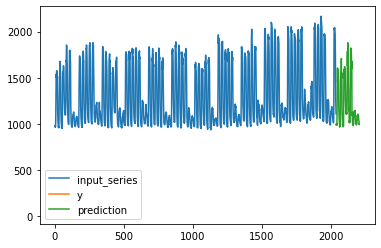

In [27]:
plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')
plt.plot(np.arange(2040, 2040+168), preds, label='prediction')
plt.legend()

In [28]:
import warnings
warnings.filterwarnings(action='ignore') 


valid_pred_array=np.zeros([60, 168])
for idx in range(train_x_array.shape[0]):
    try:
        try:
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(5, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
        except:
            print("order 4,1,1")
            
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(4, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

In [29]:
valid_pred_array.shape

(60, 168)

In [30]:
submission['answer']=valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,8177.884037
1,1 2020-08-25 01,8141.515251
2,1 2020-08-25 02,8107.113325
3,1 2020-08-25 03,8048.541587
4,1 2020-08-25 04,8036.527878
...,...,...
10075,60 2020-08-31 19,3139.810899
10076,60 2020-08-31 20,3124.444612
10077,60 2020-08-31 21,3164.565675
10078,60 2020-08-31 22,2996.758219


In [24]:
submission.to_csv('baseline_submission2.csv', index=False)